# Sentiment Analysis

## Purpose of the Project
* There are many applications of text classification. For example:
 * categorizing an email as spam or not,
 * extracting the emotion of a text.


* We will be doing sentiment analysis with Hugging Face (PyTorch).
* The goal of the project is to train a model to extract the emotion of a given text. (happy, sad, angry..). For this, we are going to use BERT based model: **DistilBERT**
* DistilBERT has as high performance as BERT but is smaller than BERT.
* Sentiment Analysis were performed with **Tensorflow** in the last part.

## Road Map of the Project
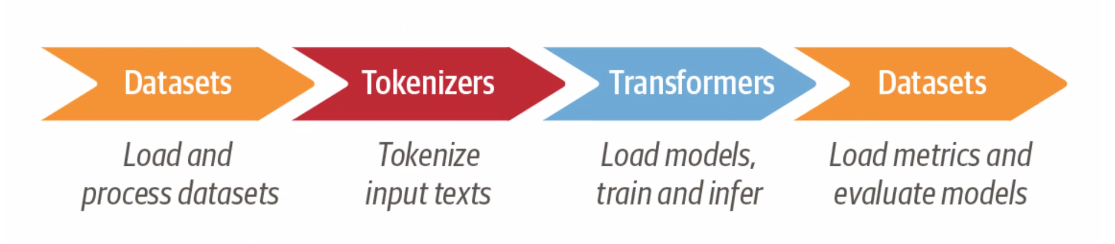

# 1- DATASET
## Importing Dataset
* This dataset consists of english tweets. 
* Dataset has 6 category. Anger, disgust, fear, joy, sadness, surprise.

In [ ]:
!pip install -q datasets

In [94]:
from datasets import load_dataset

* You can access the dataset from the link below:

https://huggingface.co/datasets/dair-ai/emotion

In [95]:
emotions = load_dataset("dair-ai/emotion")

  0%|          | 0/3 [00:00<?, ?it/s]

## Understanding Dataset

In [96]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [97]:
#exploring train set
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [98]:
len(train_ds)

16000

* train set has 16000 sample.

In [99]:
# getting the data in the index 1
train_ds[1]

{'text': 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'label': 0}

* "text" column holds the tweet text and "label" column holds the label of the tweet's emotion.

In [100]:
train_ds.column_names

['text', 'label']

In [101]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [102]:
# getting the first 5 data
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

## From Dataset to Pandas
* Converting dataset's format to Pandas format with *set_format* method

In [103]:
import pandas as pd

In [104]:
emotions.set_format(type = "pandas")

In [105]:
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


* Labels are integer, we can add their emotion labels to the table.

In [106]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

In [107]:
df["label_name"] = df["label"].apply(label_int2str)

In [108]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


## Data Visualization
* Let's draw a graph with matplotlib to see the distribution of the classes:

In [109]:
import matplotlib.pyplot as plt

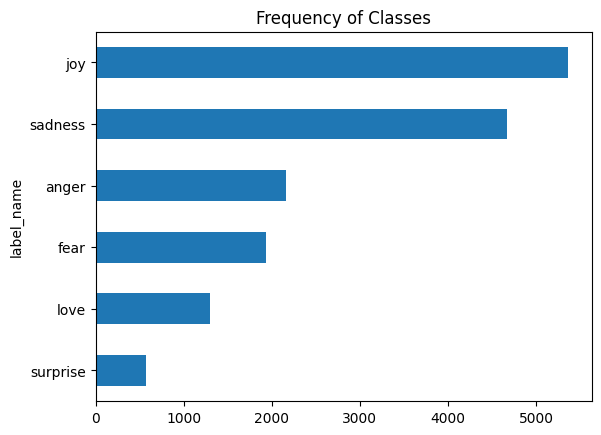

In [110]:
df["label_name"].value_counts(ascending = True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

* Visualization of post lengths by category with boxplot:

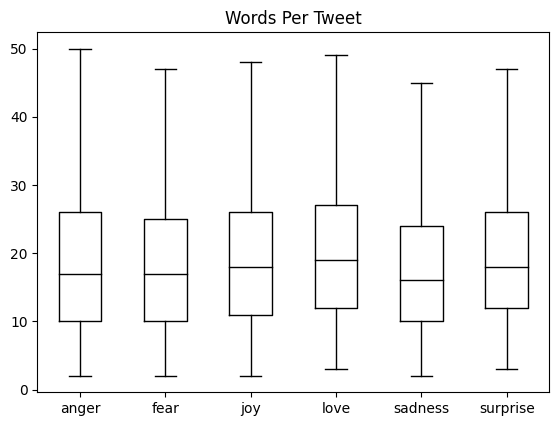

In [111]:
# calculating word count for each tweet
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by = "label_name", grid = False, showfliers = False, color = "black")
plt.suptitle("")
plt.xlabel("")
plt.show()

* We need to reset the dataset's format before data preprocessing:

In [112]:
emotions.reset_format()

# 2- DATA PREPROCESSING
* Transformers models such as DistilBERT doesn't accept raw texts as input. We need to tokenize texts to give them to the model.
* There are 3 tokenization techniques:
  * Character tokenization
  * Word tokanization
  * Subword tokenization

## 2.1- Character Tokenization

In [113]:
text = "It's fun to work with NLP using HuggingFace"

In [114]:
tokenized_text = list(text)

In [115]:
print(tokenized_text)

['I', 't', "'", 's', ' ', 'f', 'u', 'n', ' ', 't', 'o', ' ', 'w', 'o', 'r', 'k', ' ', 'w', 'i', 't', 'h', ' ', 'N', 'L', 'P', ' ', 'u', 's', 'i', 'n', 'g', ' ', 'H', 'u', 'g', 'g', 'i', 'n', 'g', 'F', 'a', 'c', 'e']


* Text is separated into characters, but the model expects each character to be an integer.

In [116]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, "'": 1, 'F': 2, 'H': 3, 'I': 4, 'L': 5, 'N': 6, 'P': 7, 'a': 8, 'c': 9, 'e': 10, 'f': 11, 'g': 12, 'h': 13, 'i': 14, 'k': 15, 'n': 16, 'o': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'w': 22}


In [117]:
# make a list of numerical representations
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[4, 20, 1, 19, 0, 11, 21, 16, 0, 20, 17, 0, 22, 17, 18, 15, 0, 22, 14, 20, 13, 0, 6, 5, 7, 0, 21, 19, 14, 16, 12, 0, 3, 21, 12, 12, 14, 16, 12, 2, 8, 9, 10]


* We should use one-hot encoding. For this we can use Pandas (*get_dummies()*) or Torch (*one_hot() method*)

## One-Hot Encoding with Torch

In [118]:
import torch

In [119]:
# converting numerical data to tensors
input_ids = torch.tensor(input_ids)

In [120]:
import torch.nn.functional as F

In [121]:
# converting the data to one-hot-encoded data
one_hot_encoding = F.one_hot(input_ids, num_classes = len(token2idx))

In [122]:
one_hot_encoding.shape

torch.Size([43, 23])

In [123]:
print(f"Token:{tokenized_text[0]}")

Token:I


In [124]:
print(f"Tensor index: {input_ids[0]}")

Tensor index: 4


* We took the first token from the text and we found it's index.
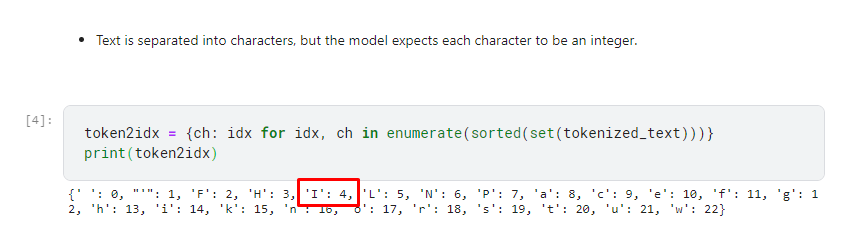

In [125]:
# one-hot vector of the fourth index
print(f"One-hot: {one_hot_encoding[0]}")

One-hot: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


## 2.2- Word Tokenization
* Character tokenization technique is used rarely. 
* Instead of dividing the text into characters, the **word tokenization** technique divides the text into words and assigns a numerical value to each word.
* This technique reduces complexity of training the model.

In [126]:
tokenized_text = text.split()
print(tokenized_text)

["It's", 'fun', 'to', 'work', 'with', 'NLP', 'using', 'HuggingFace']


* Words are seperated according to spaces.
* For each word, a weight will be assigned in the neural network. This results in a model with huge parameters and it is very difficult to train this model. To overcome this problem, we can remove less used words. However this action causes loss of some information in the text.
* Instead of this solution, **Subword Tokenization** technique can be used. This technique divides texts in a way that is in between the other two techniques.
* Subword tokenization combines the best ways of **character tokenization** and **word tokenization**.

## 2.3- Subword Tokenization

In [127]:
from transformers import AutoTokenizer

In [128]:
# importing the model
model_ckpt = "distilbert-base-uncased"

In [129]:
#loading the model's pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [130]:
#tokenize the text
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 2009, 1005, 1055, 4569, 2000, 2147, 2007, 17953, 2361, 2478, 17662, 12172, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [131]:
# exploring how to work tokenizer
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'it', "'", 's', 'fun', 'to', 'work', 'with', 'nl', '##p', 'using', 'hugging', '##face', '[SEP]']


* "##" at the beginning of words means that the word is seperated.

In [132]:
#combine seperated words
tokenizer.convert_tokens_to_string(tokens)

"[CLS] it ' s fun to work with nlp using huggingface [SEP]"

## Attributes of Tokenizer


In [133]:
# word count of distilbert tokenizer in the dictionary
tokenizer.vocab_size

30522

In [134]:
# Max length of the string to enter the model
tokenizer.model_max_length

512

## Tokenizing the Entire Dataset
* We can use **map()** method to tokenize the entire dataset.

In [135]:
def tokenize(batch):
    return tokenizer(batch["text"], truncation = True)
# The "truncate" parameter can be used to discard excess text larger than the maximum length.

In [136]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


* **"input_ids"** shows the numerical representations of the tokens, while **"attention_mask"** shows which token the model will consider

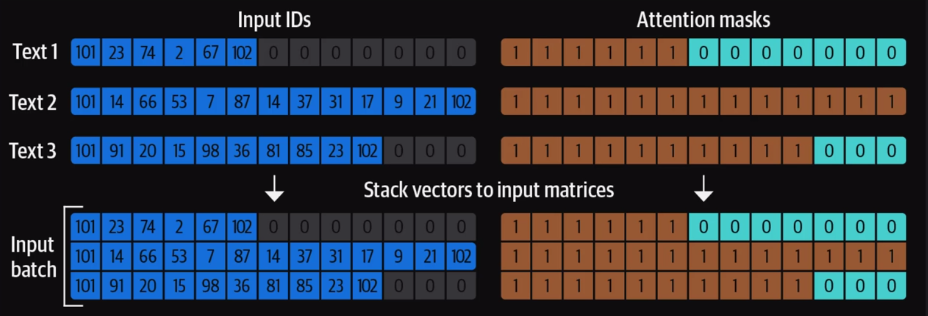

In [137]:
#tokenize the entire dataset
emotions_encoded = emotions.map(tokenize, batched = True, batch_size = None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

* Padding is done for texts less than the maximum length. (filling with zero)

In [138]:
from transformers import DataCollatorWithPadding

In [139]:
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

In [140]:
emotions_encoded["train"].column_names

['text', 'label', 'input_ids', 'attention_mask']

# 3- MODEL TRAINING

In [141]:
from transformers import AutoModelForSequenceClassification

In [142]:
num_labels = 6

In [143]:
# if you use gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

* If you tarin your model on CPU, it will be very slow. However Kaggle provides free GPU.

In [144]:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 3.1- Evaluation

In [145]:
!pip install -q evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [146]:
import evaluate

In [147]:
accuracy = evaluate.load("accuracy")

In [148]:
import numpy as np

In [149]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis = 1)
    return accuracy.compute(predictions = predictions,
                           references = labels)

## 3.2- Logging to HuggingFace

In [150]:
from huggingface_hub import notebook_login

In [151]:
notebook_login()

## 3.3- Hyperparameter Settings

In [152]:
from transformers import TrainingArguments

In [153]:
training_args = TrainingArguments(
    output_dir="distilbert-emotion",
    num_train_epochs = 2, # to determine how many times all training data will pass through the model
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy = "epoch",
    load_best_model_at_end = True,
    push_to_hub = True,
    report_to = "none"
)

## 3.4- Train the Model

In [154]:
from transformers import Trainer

In [155]:
trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset = emotions_encoded["train"],
    eval_dataset = emotions_encoded["validation"],
    tokenizer = tokenizer
)

In [ ]:
# you can select a gpu before run this code
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.235139,0.929500


Checkpoint destination directory distilbert-emotion/checkpoint-125 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


# 4- MODEL EVALUATION

In [ ]:
# Predicting the validation dataset
preds_output = trainer.predict(emotions_encoded["validation"])

In [ ]:
preds_output.metrics

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis = 1)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize = "true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                 display_labels=labels)
    disp.plot(cmap="Blues", values_format = ".2f", ax = ax,
             colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [ ]:
y_valid = np.array(emotions_encoded["validation"]["label"])
labels = emotions["train"].features["label"].names

In [ ]:
plot_confusion_matrix(y_preds, y_valid, labels)

In [ ]:
#model saving
trainer.push_to_hub(commit_message = "Training completed")

## 4.1- Prediction

In [ ]:
from transformers import pipeline

In [ ]:
model_id = "sevvalsimsek/distilbert-emotion"

In [ ]:
classifier = pipeline("text-classification", model = model_id)

In [ ]:
custom_text = "I watched a movie yesterday. It was really fun"

In [ ]:
preds = classifier(custom_text, return_all_scores = True)

In [ ]:
preds_df = pd.DataFrame(preds[0])

In [ ]:
plt.bar(labels, 100*preds_df["score"])
plt.title(f'"{custom_text}"')
plt.ylabel("Class probability (%)")
plt.show()

* Up to the present, we trained a BERT based model with **Trainer API**. This Trainer class were developed with **PyTorch**.
* You can use **Tensorflow** to train a model with Transformers.
* From this point, we are going to train a BERT-based model with Tensorflow.

# SENTIMENT ANALYSIS WITH TENSORFLOW
* The same process is valid until **tokenizer part** to train a model with Tensorflow. The difference starts with padding. 
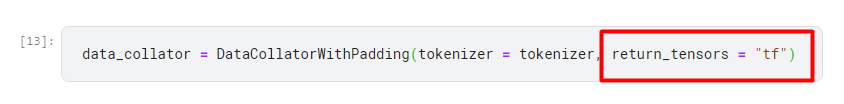
* Then, we add **"TF"** when we import a model for classification.
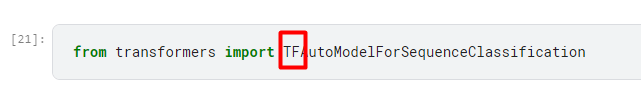

## Importing Dataset

In [1]:
!pip install -q datasets

In [2]:
from datasets import load_dataset

In [4]:
emotions = load_dataset("dair-ai/emotion")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/dair-ai___emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
emotions["train"][0]

{'text': 'i didnt feel humiliated', 'label': 0}

## Data Preprocessing

In [7]:
from transformers import AutoTokenizer

In [8]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [9]:
# applying the tokenizer to the entire dataset
def tokenize(examples):
    return tokenizer(examples["text"], truncation = True)

In [10]:
emotions_encoded = emotions.map(tokenize, batched = True, batch_size = None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [12]:
# padding
from transformers import DataCollatorWithPadding

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [13]:
data_collator = DataCollatorWithPadding(tokenizer = tokenizer, return_tensors = "tf")

In [14]:
# set model metrics (with evaluate library)
!pip install -q evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [15]:
import evaluate

In [16]:
accuracy = evaluate.load("accuracy")

In [18]:
import numpy as np
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis = 1)
    return accuracy.compute(predictions =predictions, references = labels)

## Model Training
* We're gonna import our model from hub and then we'll fine-tune it.

In [20]:
id2label = {0: "sadness", 1:"joy", 2:"love", 3:"anger", 4:"fear", 5:"suprise"}
label2id= {"sadness":0,"joy":1,"love":2,"anger":3,"fear":4,"suprise":5}

In [21]:
from transformers import TFAutoModelForSequenceClassification

In [23]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = 6, id2label = id2label,label2id = label2id)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [24]:
from huggingface_hub import notebook_login
notebook_login()

In [25]:
# preparing the dataset
tf_train_set = model.prepare_tf_dataset(
    emotions_encoded["train"],
    shuffle = True,
    batch_size = 16,
    collate_fn = data_collator
)

tf_validation_set = model.prepare_tf_dataset(
    emotions_encoded["validation"],
    shuffle = True,
    batch_size = 16,
    collate_fn = data_collator
)

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.10/site-packages/datasets/formatting/formatting.py:197: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  (isinstance(x, np.ndarray) and (x.dtype == np.object or x.shape != array[0].shape))


AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [26]:
import tensorflow as tf

In [27]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 5e5)

In [28]:
model.compile(optimizer = optimizer)

In [29]:
# setting callbacks to see the model's performance
from transformers.keras_callbacks import KerasMetricCallback

In [30]:
metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics,
    eval_dataset = tf_validation_set
)

NameError: name 'tf_validation_set' is not defined

In [33]:
# save the model
from transformers.keras_callbacks import PushToHubCallback

In [34]:
push_to_hub_callback = PushToHubCallback(
    output_dir = "emotion-analysis-with-distilbert",
    tokenizer = tokenizer
)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/sevvalsimsek/emotion-analysis-with-distilbert into local empty directory.


In [ ]:
# we use fit() method to train a model
model.fit(x=tf_train_set,
         validation_data=tf_validation_set,
         epochs=2,
         callbacks=[metric_callback, push_to_hub_callback])

## Prediction

In [35]:
custom_text = "I watched a movie yesterday. It was really awesome"

In [ ]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", 
                     model = "sevvalsimsek/emotion-analysis-with-distilbert")

In [ ]:
# tokenize the text
inputs=tokenizer(custom_text, return_tensors= "tf")

In [ ]:
logits = model(**inputs).logits

In [ ]:
predicted_class_id=int(tf.math.argmax(logits, axis=-1)[0])

In [ ]:
# see the label corresponding to the id
model.config.id2label[predicted_class_id]